In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir='/content/drive/MyDrive/summer intern/dataset/train'
test_data_dir='/content/drive/MyDrive/summer intern/dataset/test'
val_data_dir='/content/drive/MyDrive/summer intern/dataset/valid'

In [4]:
classes=[str(i) for i in range(6)]

In [5]:
train_images_per_class=500

In [7]:
def gen_circle(img: np.ndarray, center: tuple, diameter: int,fill_val: int) -> np.ndarray:
  
    """
        Creates a matrix of ones filling a circle.
    """

    # gets the radius of the image
    radius  = diameter//2

    # gets the row and column center of the image
    row, col = center 

    # generates theta vector to variate the angle
    theta = np.arange(0, 360)*(np.pi/180)

    # generates the indexes of the column
    y = (radius*np.sin(theta)).astype("int32") 

    # generates the indexes of the rows
    x = (radius*np.cos(theta)).astype("int32") 

    # with:
    # img[x, y] = 1
    # you can draw the border of the circle 
    # instead of the inner part and the border. 

    # centers the circle at the input center
    rows = x + (row)
    cols  = y + (col)

    # gets the number of rows and columns to make 
    # to cut by half the execution
    nrows = rows.shape[0] 
    ncols = cols.shape[0]

    # makes a copy of the image
    img_copy = np.copy(img)

    # We use the simetry in our favour
    # does reflection on the horizontal axes 
    # and in the vertical axes

    for row_down, row_up, col1, col2 in zip(rows[:nrows//4],
                            np.flip(rows[nrows//4:nrows//2]),
                            cols[:ncols//4],
                            cols[nrows//2:3*ncols//4]):
    
        img_copy[row_up:row_down, col2:col1] = fill_val

 
    return img_copy

In [6]:
starting_class,ending_class=(4,5)

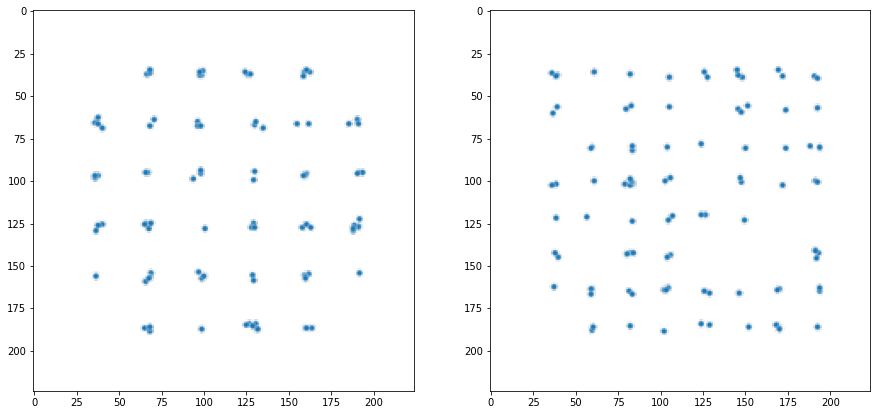

In [9]:
from matplotlib import pyplot as plt
from PIL import Image
 
# Opens a image in RGB mode
newsize=(224,224)

sample_imgs=[8,6]
imgs=[]
for i in range(starting_class,ending_class+1):
  imgs.append(Image.open("/content/drive/MyDrive/summer intern/dataset/train/"+str(i)+'/'+str(sample_imgs[i-4])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 1
columns = 2


for i in range(2):
  # Adds a subplot at the ith position
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(imgs[i])

  
# showing image

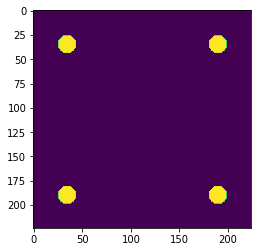

In [35]:
# R filter
#four corner circles

diameter=20
r_filter_dim=[(35,35),(190,35),(35,190),(190,190)]
fil=np.zeros((224,224),dtype=int)
for i in range(4):
    fil=gen_circle(fil,r_filter_dim[i],diameter,1);
plt.imshow(fil)

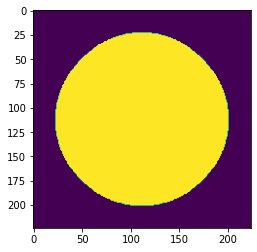

In [25]:
# G filter
# a circle
diameter_g=180
g_filter_dim=(112,112)
fil=np.zeros((224,224),dtype=int)
fil=gen_circle(fil,g_filter_dim,diameter_g,1)
plt.imshow(fil)

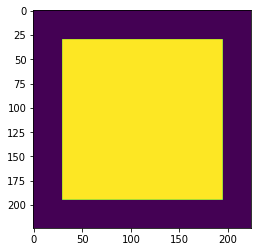

In [30]:
# B filter

#One square
b_filter_dim=[30,195]
fil=np.zeros((224,224),dtype=int)
#1st rectangle
for i in range(b_filter_dim[0],b_filter_dim[1]):
  for j in range(b_filter_dim[0],b_filter_dim[1]):
    fil[i][j]=1
plt.imshow(fil)

In [37]:
def apply_filter(im):
  center = (112,112)
  #four corner circles
  #red layer filter
  diameter=20
  r_filter_dim=[(35,35),(190,35),(35,190),(190,190)]
  fil=np.zeros((224,224),dtype=int)
  for i in range(4):
      fil=gen_circle(fil,r_filter_dim[i],diameter,1); 
  
  im[:,:,0]=im[:,:,0]*fil


  #green layer filter
  # G filter
# a circle
  diameter_g=180
  g_filter_dim=(112,112)
  fil=np.zeros((224,224),dtype=int)
  fil=gen_circle(fil,g_filter_dim,diameter_g,1)
  im[:,:,1]=im[:,:,1]*fil


  #blue layer filter
  b_filter_dim=[30,195]
  fil=np.zeros((224,224),dtype=int)
  #1st rectangle
  for i in range(b_filter_dim[0],b_filter_dim[1]):
    for j in range(b_filter_dim[0],b_filter_dim[1]):
      fil[i][j]=1
  im[:,:,2]=im[:,:,2]*fil
  
  return im

In [32]:
def disp_filter_image(im):
  im=apply_filter(im)
  plt.imshow(im)
  plt.axis('off')

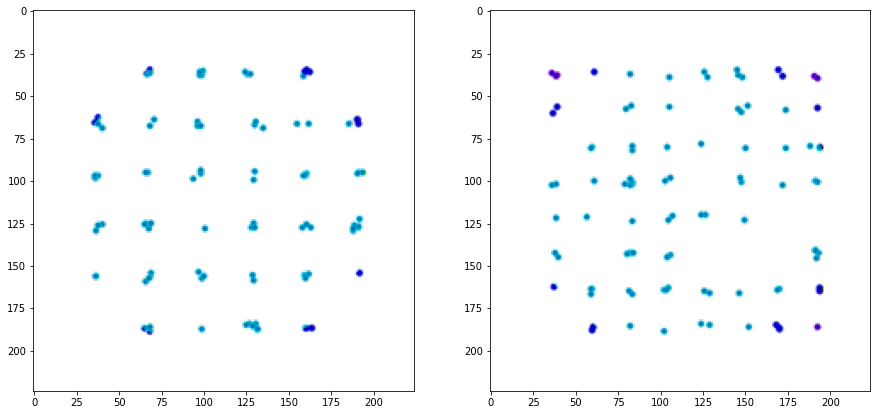

In [38]:
fil_imgs=[]
for i in range(2):
  fil_imgs.append(Image.open("/content/drive/MyDrive/summer intern/dataset/train/"+str(i+4)+'/'+str(sample_imgs[i])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 1
columns = 2

for i in range(2):
  # Adds a subplot at the ith position
  fil_imgs[i]=apply_filter(np.array(fil_imgs[i]))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(fil_imgs[i])

In [41]:
train_data=[]
train_label=[]
img_height,img_width=224,224
for cls in classes[starting_class:ending_class+1]:
  print(cls)
  for i in range(train_images_per_class):
    img_path=data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=image.img_to_array(img)
    train_data.append(img_data)
    train_label.append(int(cls))

4
5


In [42]:
train_label[:train_images_per_class]=[0]*train_images_per_class
train_label[train_images_per_class:]=[1]*train_images_per_class

In [43]:
valid_images_per_class=100

In [44]:
valid_data=[]
valid_label=[]
img_height,img_width=224,224
for cls in classes[starting_class:ending_class+1]:
  print(cls)
  for i in range(valid_images_per_class):
    img_path=val_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=image.img_to_array(img)
    valid_data.append(img_data)
    valid_label.append(int(cls))


4
5


In [45]:
valid_label=[]
valid_label[:valid_images_per_class]=[0]*valid_images_per_class
valid_label[valid_images_per_class:]=[1]*valid_images_per_class

In [46]:
train_data=np.asarray(train_data)
train_label=np.asarray(train_label)

In [47]:
valid_data=np.asarray(valid_data)
valid_label=np.asarray(valid_label)

In [48]:
for i in range(len(train_label)):
  train_data[i]=apply_filter(train_data[i])

In [49]:
for i in range(len(valid_label)):
  valid_data[i]=apply_filter(valid_data[i])

In [50]:
def preprocess_data(X,Y,n):
  X_p=preprocess_input(X)
  Y_p=tf.keras.utils.to_categorical(Y,n)
  return (X_p,Y_p)

In [51]:
train_data,train_label=preprocess_data(train_data,train_label,2)

In [52]:
valid_data,valid_label=preprocess_data(valid_data,valid_label,2)

In [53]:
print(train_data.shape,train_label.shape)

(1000, 224, 224, 3) (1000, 2)


In [54]:
resnet_model = Sequential()
input_t=tf.keras.Input(shape=(224,224,3))
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_tensor=input_t,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 4s 0us/step


In [55]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [56]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [57]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_data,train_label, validation_data=(valid_data,valid_label),batch_size=32, epochs=25,verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
32/32 [==============================] - 194s 6s/step - loss: 6.6641 - accuracy: 0.5940 - val_loss: 0.8628 - val_accuracy: 0.6700
Epoch 2/25
32/32 [==============================] - 189s 6s/step - loss: 0.6626 - accuracy: 0.7230 - val_loss: 2.2895 - val_accuracy: 0.5600
Epoch 3/25
32/32 [==============================] - 192s 6s/step - loss: 0.9835 - accuracy: 0.6920 - val_loss: 0.5898 - val_accuracy: 0.7100
Epoch 4/25
32/32 [==============================] - 189s 6s/step - loss: 0.4986 - accuracy: 0.7550 - val_loss: 0.5334 - val_accuracy: 0.7450
Epoch 5/25
32/32 [==============================] - 191s 6s/step - loss: 0.4412 - accuracy: 0.7800 - val_loss: 0.4416 - val_accuracy: 0.7700
Epoch 6/25
32/32 [==============================] - 189s 6s/step - loss: 0.5517 - accuracy: 0.7410 - val_loss: 0.4339 - val_accuracy: 0.7800
Epoch 7/25
32/32 [==============================] - 189s 6s/step - loss: 0.4762 - accuracy: 0.7650 - val_loss: 0.4449 - val_accuracy: 0.7500
Epoch 8/25
32

KeyboardInterrupt: ignored

In [58]:
test_images_per_class=100

In [59]:
test_data=[]
test_label=[]
img_height,img_width=224,224
for cls in classes[starting_class:ending_class+1]:
  print(cls)
  for i in range(100):
    img_path=test_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=image.img_to_array(img)
    test_data.append(img_data)
    test_label.append(int(cls))


4
5


In [60]:
test_label=[]
test_label[:test_images_per_class]=[0]*test_images_per_class
test_label[test_images_per_class:]=[1]*test_images_per_class

In [61]:
test_data=np.asarray(test_data)
test_label=np.asarray(test_label)

In [62]:
for i in range(len(test_label)):
  test_data[i]=apply_filter(test_data[i])

In [63]:
test_data,test_label=preprocess_data(test_data,test_label,2)

In [64]:
test_data.shape,test_label.shape

((200, 224, 224, 3), (200, 2))

In [65]:
test_loss,test_acc=resnet_model.evaluate(test_data,test_label,verbose=1)

7/7 [==============================] - 34s 5s/step - loss: 0.5002 - accuracy: 0.7250


In [66]:
print('Testing data accuracy = '+str(test_acc)+'\n Testing data loss = '+str(test_loss))

Testing data accuracy = 0.7250000238418579
 Testing data loss = 0.5002260208129883


In [67]:
from tensorflow.keras.models import model_from_json

In [68]:
model_json = resnet_model.to_json()
with open("/content/drive/MyDrive/summer intern/Models/filter_model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
resnet_model.save_weights("/content/drive/MyDrive/summer intern/Models/filter_model_5.h5")
print("Saved model to disk")
 
# later...
 


Saved model to disk
